<img src="https://www.ibm.com/watson/health/ai-stories/assets/images/ibm-watson-health-logo.png" style="float: left; width: 40%; margin-bottom: 0.5em;">

## Develop a neuropathy onset predictive model using the FHIR diabetic patient data (prepared in Notebook 2)
**FHIR Dev Day Notebook 3**
Author: **Gigi Yuen-Reed** <gigiyuen@us.ibm.com>

[Section 1: Environment setup and credentials](#section_1)  
[Section 2: Data ingestion](#section_2)  
[Section 3: Data understanding](#section_3)  
[Section 4: Construct analysis cohort](#section_4)  
[Section 5: Model development and validation](#section_5)  

<a id='section_1'></a>
## 1. Environment setup and credentails

In [5]:
import types
import pandas as pd
import ibm_boto3
import glob
from ibm_botocore.client import Config
from pprint import pprint
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import set_printoptions

import ibmos2spark
from pyspark.sql.functions import *
from pyspark.sql.types import *

# import ML packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import classification_report

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [6]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [7]:
# Temporary credentials provided for DevDays only

synthetic_mass_read_only = \
{
  "apikey": "HNJj8lVRmT-wX-n3ns2d8A8_iLFITob7ibC6aH66GZQX",
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key 418c8c60-5c31-4ed0-8a08-0f6641a01d46",
  "iam_apikey_name": "dev_days",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Reader",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/f0dfe396162db060e2e2a53ff465dfa0::serviceid:ServiceId-e13864d8-8b73-4901-8060-b84123e5ca1c",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/f0dfe396162db060e2e2a53ff465dfa0:3067bed7-8108-4d6e-ba32-5d5f643700e5::"
}

In [8]:
cos_api_key = synthetic_mass_read_only
input_bucket = 'whc-save-fhir'

credentials = {
    'service_id': cos_api_key['iam_serviceid_crn'],
    'api_key': cos_api_key['apikey'],
    'endpoint': 'https://s3.private.us-south.cloud-object-storage.appdomain.cloud',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'
}

configuration_name = 'syntheticmass-write' #Must be unique for each bucket / configuration!
spark_cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

In [9]:
# COS API setup
client = ibm_boto3.client(
    service_name='s3',
    ibm_api_key_id=cos_api_key['apikey'],
    ibm_auth_endpoint=credentials['iam_service_endpoint'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['endpoint'])

# explore what is inside the COS bucket
# client.list_objects(Bucket=input_bucket).get('Contents')

<a id='section_2'></a>
## 2. Data ingestion
Read in LPR generated from Notebook 2.  Recall LPR_Row contains diabetic patient data where each observation represents an unqiue patient-comorbidty combination

In [10]:
# versify COS bucket location
input_file = 'lpr/lpr_row'
spark_cos.url(input_file, input_bucket)

'cos://whc-save-fhir.syntheticmass-write/lpr/lpr_row'

In [11]:
# read in LPR_row

%time lprRow = spark.read.parquet(spark_cos.url(input_file, input_bucket))

lprRow.count()

CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 12.3 s


21982

In [12]:
lprRow.limit(20)

patient_id,birth_date,gender,target_code,target_name,snomed_code,snomed_name,target_first_date,first_observation_date,last_observation_date
05add0ab-60f6-4f7...,1962-02-17,female,44054006,Diabetes,38341003,Hypertension,1990-04-28,1990-04-28,1990-04-28
05add0ab-60f6-4f7...,1962-02-17,female,44054006,Diabetes,127013003,Diabetic renal di...,1990-04-28,1994-01-08,1994-01-08
05add0ab-60f6-4f7...,1962-02-17,female,44054006,Diabetes,90781000119102,Microalbuminuria ...,1990-04-28,2003-04-05,2003-04-05
05add0ab-60f6-4f7...,1962-02-17,female,44054006,Diabetes,368581000119106,Neuropathy due to...,1990-04-28,2003-04-05,2003-04-05
05add0ab-60f6-4f7...,1962-02-17,female,44054006,Diabetes,230690007,Stroke,1990-04-28,2010-08-28,2010-08-28
0a91758c-3046-423...,1955-02-16,female,44054006,Diabetes,127013003,Diabetic renal di...,2001-12-19,2011-08-24,2011-08-24
0d9fefa1-a58e-44f...,1942-02-14,female,44054006,Diabetes,38341003,Hypertension,1986-05-10,1986-05-10,1986-05-10
0d9fefa1-a58e-44f...,1942-02-14,female,44054006,Diabetes,368581000119106,Neuropathy due to...,1986-05-10,1992-02-15,1992-02-15
0d9fefa1-a58e-44f...,1942-02-14,female,44054006,Diabetes,127013003,Diabetic renal di...,1986-05-10,1996-03-09,1996-03-09
0dd16757-e8af-4e7...,1953-10-03,male,44054006,Diabetes,38341003,Hypertension,1974-06-29,1971-11-27,1971-11-27


In [13]:
# load into pandas (no longer distributed)
%time df = lprRow.toPandas()
df.info()

CPU times: user 152 ms, sys: 4 ms, total: 156 ms
Wall time: 4.96 s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21982 entries, 0 to 21981
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   patient_id              21982 non-null  object
 1   birth_date              21982 non-null  object
 2   gender                  21982 non-null  object
 3   target_code             21982 non-null  object
 4   target_name             21982 non-null  object
 5   snomed_code             21982 non-null  object
 6   snomed_name             21982 non-null  object
 7   target_first_date       21982 non-null  object
 8   first_observation_date  21982 non-null  object
 9   last_observation_date   21982 non-null  object
dtypes: object(10)
memory usage: 1.7+ MB


In [14]:
print("panda dataframe size: ", df.shape)

panda dataframe size:  (21982, 10)


In [15]:
# store snomed code to name mapping => next iteration, upgrade to storing mapping in dictionary
from pandas import DataFrame
snomed_map  = df.groupby(['snomed_code', 'snomed_name']).first().index.tolist() #a list
mapdf = DataFrame(snomed_map,columns=['snomed_code','snomed_name']) #a dataframe
mapdf

,snomed_code,snomed_name
0,127013003,Diabetic renal disease (disorder)
1,1501000119109,Proliferative diabetic retinopathy due to type II diabetes mellitus (disorder)
2,1551000119108,Nonproliferative diabetic retinopathy due to type 2 diabetes mellitus (disorder)
3,157141000119108,Proteinuria due to type 2 diabetes mellitus (disorder)
4,161621004,History of upper limb amputation (situation)
5,161622006,History of lower limb amputation (situation)
6,195967001,Asthma
7,230690007,Stroke
8,368581000119106,Neuropathy due to type 2 diabetes mellitus (disorder)
9,38341003,Hypertension


<a id='section_3'></a>
## 3. Data Understanding
Data exploration and use case validation.  Please note that the patient data characteristics are likely the artifact of Synetha's data generation engine, they may not reflect the nuance and diversity of disease progression one would observed in practice.

**Clinical references**    
Top diabetic comorbidities, see example in Nowakowska et al (2019) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6659216/    
Common diabetic complications, see the US CDC list https://www.cdc.gov/diabetes/library/features/prevent-complications.html
    

In [16]:
# unique patient count
n = len(pd.unique(df['patient_id'])) 
print("number of unique patients = ", n)

number of unique patients =  7393


In [17]:
# review prevalence of co-morbidities
df.snomed_name.value_counts()

Hypertension                                                                        4720
Diabetic renal disease (disorder)                                                   3831
Neuropathy due to type 2 diabetes mellitus (disorder)                               3158
Diabetic retinopathy associated with type II diabetes mellitus (disorder)           2466
Nonproliferative diabetic retinopathy due to type 2 diabetes mellitus (disorder)    1483
Coronary Heart Disease                                                              1231
Microalbuminuria due to type 2 diabetes mellitus (disorder)                         1129
Stroke                                                                              1093
Osteoporosis (disorder)                                                              678
Atrial Fibrillation                                                                  672
Macular edema and retinopathy due to type 2 diabetes mellitus (disorder)             544
Proliferative diabeti

**Observation**: Hypertension, diabetic renal disease and neuropathy due to T2D are the top 3 co-morbidities for diabetic patients.  About 40% of our diabetic population has neuropathy at some point in their lives

In [18]:
# set date format 
df['birth_date'] = pd.to_datetime(df['birth_date'])
df['target_first_date'] = pd.to_datetime(df['target_first_date'])
df['first_observation_date'] = pd.to_datetime(df['first_observation_date'])

# calculate patient age at diabete onset
df['onsetAge'] = (df['target_first_date'] - df['birth_date'])/ pd.to_timedelta(1, unit='D') / 365
df.head()

,patient_id,birth_date,gender,target_code,target_name,snomed_code,snomed_name,target_first_date,first_observation_date,last_observation_date,onsetAge
0,021cd470-72e4-49df-8ccc-ea9d5ea22783,1965-02-14,female,44054006,Diabetes,38341003,Hypertension,2009-03-01,1983-03-27,1983-03-27,44.071233
1,07013afa-7c6b-4fd2-bc70-4a0f083a2a22,1976-08-03,male,44054006,Diabetes,38341003,Hypertension,2013-11-12,2013-11-12,2013-11-12,37.301370
2,0b07035a-d987-46c8-aed1-cbbbd092d066,1986-10-05,female,44054006,Diabetes,368581000119106,Neuropathy due to type 2 diabetes mellitus (disorder),2015-12-20,2018-12-23,2018-12-23,29.227397
3,11542ea6-91b1-4dd8-8013-9d68ac076608,1957-02-22,female,44054006,Diabetes,38341003,Hypertension,1979-06-01,1975-05-23,1975-05-23,22.284932
4,11542ea6-91b1-4dd8-8013-9d68ac076608,1957-02-22,female,44054006,Diabetes,368581000119106,Neuropathy due to type 2 diabetes mellitus (disorder),1979-06-01,1992-03-13,1992-03-13,22.284932


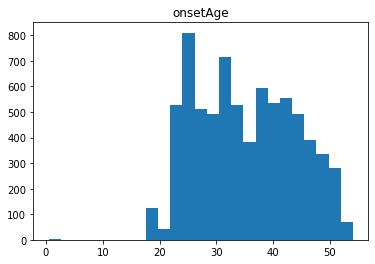

In [19]:
# review patient age at diabetes onset
firstdf = df.groupby('patient_id').first().reset_index()
onsetAgePlot = firstdf.hist(column='onsetAge', bins=25, grid=False)

In [20]:
# review co-morbidities onset timing in comparison to diabetic onset 
# positive means co-morbidity was first reported AFTER onset; negative means BEFORE)
df['yearDiff'] = (df['first_observation_date'] - df['target_first_date']) / pd.to_timedelta(1, unit='D') / 365
df.head()

,patient_id,birth_date,gender,target_code,target_name,snomed_code,snomed_name,target_first_date,first_observation_date,last_observation_date,onsetAge,yearDiff
0,021cd470-72e4-49df-8ccc-ea9d5ea22783,1965-02-14,female,44054006,Diabetes,38341003,Hypertension,2009-03-01,1983-03-27,1983-03-27,44.071233,-25.947945
1,07013afa-7c6b-4fd2-bc70-4a0f083a2a22,1976-08-03,male,44054006,Diabetes,38341003,Hypertension,2013-11-12,2013-11-12,2013-11-12,37.301370,0.000000
2,0b07035a-d987-46c8-aed1-cbbbd092d066,1986-10-05,female,44054006,Diabetes,368581000119106,Neuropathy due to type 2 diabetes mellitus (disorder),2015-12-20,2018-12-23,2018-12-23,29.227397,3.010959
3,11542ea6-91b1-4dd8-8013-9d68ac076608,1957-02-22,female,44054006,Diabetes,38341003,Hypertension,1979-06-01,1975-05-23,1975-05-23,22.284932,-4.027397
4,11542ea6-91b1-4dd8-8013-9d68ac076608,1957-02-22,female,44054006,Diabetes,368581000119106,Neuropathy due to type 2 diabetes mellitus (disorder),1979-06-01,1992-03-13,1992-03-13,22.284932,12.791781


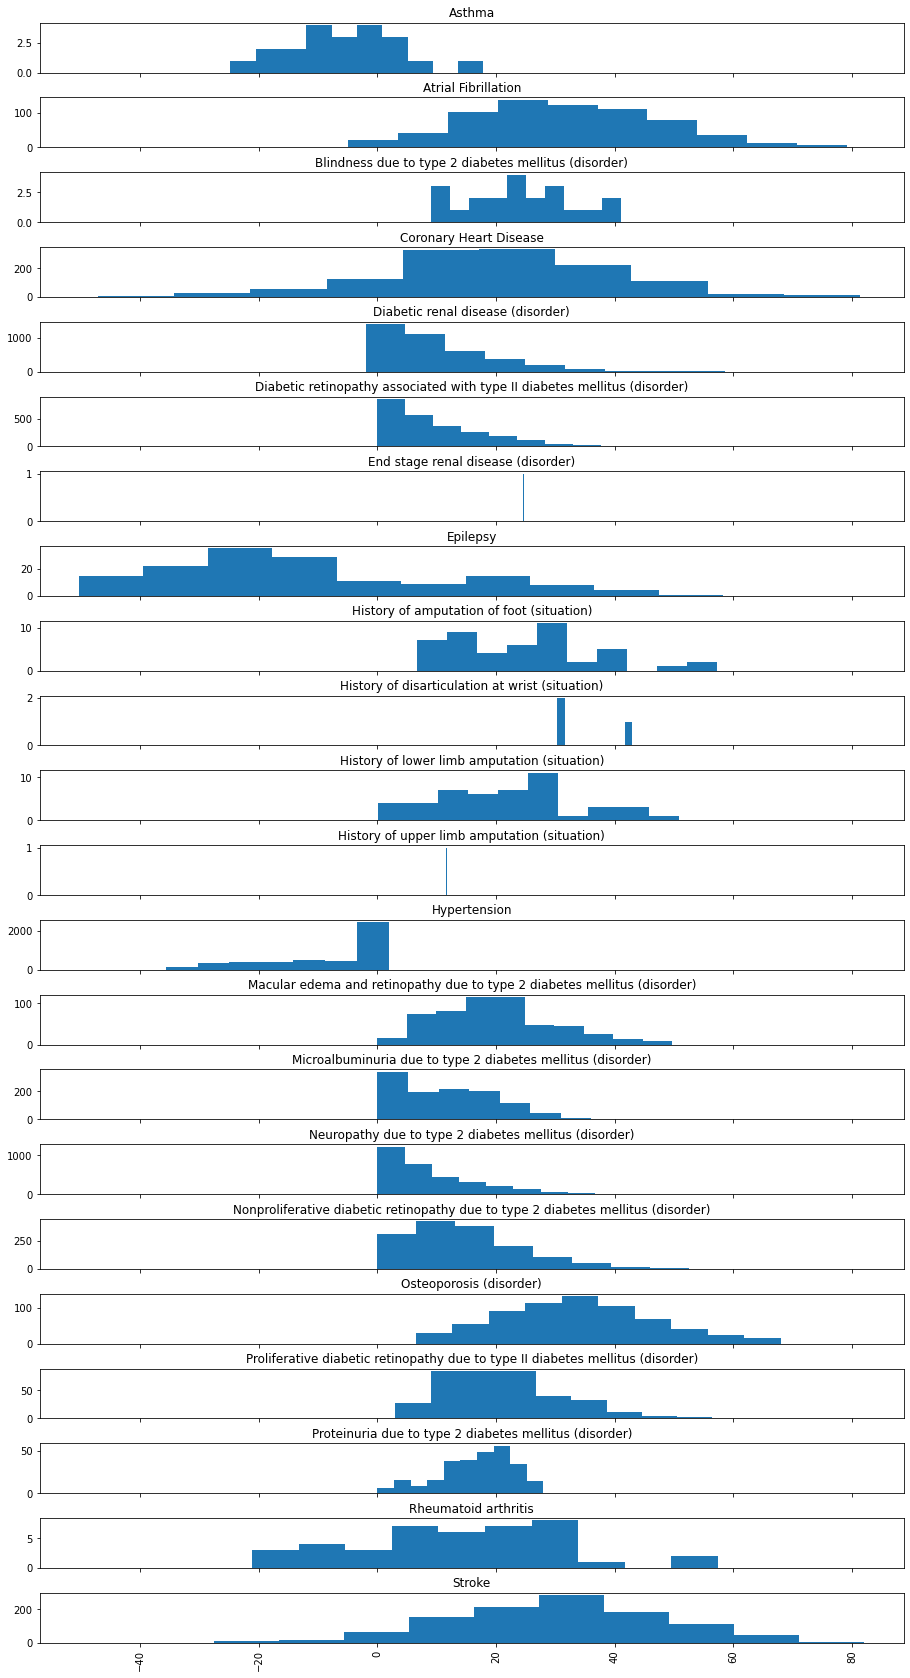

In [21]:
#plot histrogram of onset time difference(in years) by comorbidity 
onsetDiffPlot = df.hist(column='yearDiff', by='snomed_name', bins=10, grid=False, figsize=(15,30), layout=(22,1), sharex=True)

**Observation**: Majority of co-morbidities were first reported AFTER diabetic onset, recall this is a synethic dataset. 

In [22]:
# review data availability dates
print("diabetic onset date ranges", df.target_first_date.min(), df.target_first_date.max())
print("comorbidity start date ranges", df.first_observation_date.min(), df.first_observation_date.max())
print("comorbidity end date ranges",df.last_observation_date.min(), df.last_observation_date.max())

diabetic onset date ranges 1927-10-09 00:00:00 2019-04-12 00:00:00
comorbidity start date ranges 1908-06-18 00:00:00 2019-04-17 00:00:00
comorbidity end date ranges 1908-06-18 2019-04-17


<a id='section_4'></a>
## 4. Construct analysis cohort
Model Objective: What is the likelihood of developing neuropathy 5 years after onset?
Observation period: Demographic and known comorbidities as of diabetic onset
Prediction period: 5 years after diabetic onset

### 4.1 Define patient cohort with inclusion/exclusion criteria

In [23]:
# cohort exclusion 1: remove patients who has neuropathy due to diabetes diagnosis prior to diabetes onset date
e1 = df[(df["snomed_code"]=="368581000119106") & (df["yearDiff"]<0)][['patient_id']]
print("number of unique patients in exclusion 1: ", len(pd.unique(e1['patient_id'])))

number of unique patients in exclusion 1:  0


In [24]:
# cohort exclusion 2: remove patients who has less than 3 year of data prior to diabetes onset
e2 = df[df["target_first_date"] < pd.Timestamp('19301009')][['patient_id']]
print("number of unique patients in exclusion 2: ", len(pd.unique(e2['patient_id'])))

number of unique patients in exclusion 2:  7


In [25]:
# cohort exclusion 3: remove patient has less than 5 years of data in prediction window 
e3 = df[df["target_first_date"] > pd.Timestamp('20140417')][['patient_id']]
print("number of unique patients in exclusion 3: ", len(pd.unique(e3['patient_id'])))

number of unique patients in exclusion 3:  524


In [26]:
# cohort exclusion 4: patient age at diabetic onset >= 18
e4 = df[df["onsetAge"] < 18][['patient_id']]
print("number of unique patients in exclusion 4: ", len(pd.unique(e4['patient_id'])))

number of unique patients in exclusion 4:  5


In [27]:
# construct cohort - remove all records for patients that meet any of the 4 exclusion criteria

# total patient count prior to filtering
# n = len(pd.unique(df['patient_id'])) #repeat from earlier
print("number of unique patients prior to filtering = ", n)

cohort = df[ (~df['patient_id'].isin(e1['patient_id'])) & (~df['patient_id'].isin(e2['patient_id'])) & (~df['patient_id'].isin(e3['patient_id'])) & (~df['patient_id'].isin(e4['patient_id']))]
print(cohort.shape)
print(len(pd.unique(cohort['patient_id'])))

# alternative 1:
# e4 = df[df["onsetAge"] < 18][['patient_id']]
# update_df = df.drop(e4.index, axis=0)

# alternative 2: 
# e4 = df[df["onsetAge"] < 18][['patient_id']].index.tolist()
# update_df = df.drop(e4) 

number of unique patients prior to filtering =  7393
(21247, 12)
6857


### 4.2 Construct model input features and prediction target
Develop model inputs, codify prediction target, normalize data

In [28]:
# step 1: transpose table such that each row is a patient
temp1 = cohort.loc[:,['patient_id','gender','onsetAge']]
temp1 = temp1.drop_duplicates(subset=['patient_id'])
print("patient demographic block size: ", temp1.shape)

temp2 = cohort.pivot_table(index=["patient_id"], columns='snomed_code', values='yearDiff')
print("patient condition block size: ", temp2.shape)

cohort1 = temp1.merge(temp2, left_on="patient_id", right_on="patient_id")
print("combined patient block size: ", cohort1.shape)
cohort1.head()

patient demographic block size:  (6857, 3)
patient condition block size:  (6857, 22)
combined patient block size:  (6857, 25)


,patient_id,gender,onsetAge,127013003,1501000119109,1551000119108,157141000119108,161621004,161622006,195967001,230690007,368581000119106,38341003,422034002,429280009,46177005,49436004,53741008,60951000119105,64859006,698423002,69896004,84757009,90781000119102,97331000119101
0,021cd470-72e4-49df-8ccc-ea9d5ea22783,female,44.071233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25.947945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,07013afa-7c6b-4fd2-bc70-4a0f083a2a22,male,37.301370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11542ea6-91b1-4dd8-8013-9d68ac076608,female,22.284932,20.482192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.791781,-4.027397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1dd24ce5-9db8-4c11-841a-f75dca6b0af0,female,34.443836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1e0bd7b8-8833-4aef-b159-8fdd93229523,male,50.035616,21.345205,NaN,NaN,NaN,NaN,NaN,NaN,31.547945,NaN,NaN,NaN,NaN,NaN,NaN,6.09863,NaN,10.164384,NaN,NaN,NaN,NaN,NaN


In [29]:
# set target: neuropathy (368581000119106)
cohort1.rename(columns={"368581000119106":"target"}, inplace=True)

# demographic features
demographic = ["onsetAge", "gender"]

# condition features
temp3 = cohort1.drop(["patient_id", "onsetAge", "gender"], axis=1)
condition_list = list(temp3)
print (condition_list)

['127013003', '1501000119109', '1551000119108', '157141000119108', '161621004', '161622006', '195967001', '230690007', 'target', '38341003', '422034002', '429280009', '46177005', '49436004', '53741008', '60951000119105', '64859006', '698423002', '69896004', '84757009', '90781000119102', '97331000119101']


In [30]:
# prepare condition features: value = 1 if condition was pre-existing to diabetes onset
for column in cohort1[condition_list]:
    cohort1[column] = cohort1[column].apply(lambda x: 1 if x <= 0 else 0)

# prepare gender input features, female = 1 male =0
cohort1["gender"] = cohort1["gender"].apply(lambda x: 1 if x == "male" else 0)

# prepare target value = 1 if neuropathy occurs within 5 years AFTER diabetes onset
cohort1["target"] = cohort1["target"].apply(lambda x: 1 if (x > 0) & (x <=5) else 0)

In [31]:
# construct new feature: number of knwon comorbidities as of diabetic onset
cohort1['comorbid_ct'] = cohort1[condition_list].sum(axis=1)
cohort1.head(10)

,patient_id,gender,onsetAge,127013003,1501000119109,1551000119108,157141000119108,161621004,161622006,195967001,230690007,target,38341003,422034002,429280009,46177005,49436004,53741008,60951000119105,64859006,698423002,69896004,84757009,90781000119102,97331000119101,comorbid_ct
0,021cd470-72e4-49df-8ccc-ea9d5ea22783,0,44.071233,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,07013afa-7c6b-4fd2-bc70-4a0f083a2a22,1,37.301370,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,11542ea6-91b1-4dd8-8013-9d68ac076608,0,22.284932,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1dd24ce5-9db8-4c11-841a-f75dca6b0af0,0,34.443836,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1e0bd7b8-8833-4aef-b159-8fdd93229523,1,50.035616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2205ed61-e669-4bfa-9676-9f66d481a760,1,31.221918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,253bc90d-409b-4a9f-84ab-293b9fcc9f1c,0,44.071233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2574395f-12c2-4a00-8953-89a39a818bfe,1,52.126027,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
8,2726cdbe-5241-459f-8793-e7f71b70a417,0,31.816438,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
9,2f8495a2-28ae-4594-85ab-e7c669e4b2c4,1,48.098630,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [32]:
# verify cohort characteristics
cohort1.mean()

gender              0.556657
onsetAge           35.029174
127013003           0.051626
1501000119109       0.000000
1551000119108       0.003646
157141000119108     0.000146
161621004           0.000000
161622006           0.000000
195967001           0.002188
230690007           0.006854
target              0.047543
38341003            0.622138
422034002           0.034417
429280009           0.000000
46177005            0.000000
49436004            0.001021
53741008            0.017646
60951000119105      0.000000
64859006            0.000000
698423002           0.000000
69896004            0.001021
84757009            0.014000
90781000119102      0.004521
97331000119101      0.000146
comorbid_ct         0.806913
dtype: float64

In [33]:
cohort1.groupby("target").describe()

gender                                              onsetAge  \
         count      mean       std  min  25%  50%  75%  max    count   
target                                                                 
0       6531.0  0.558873  0.496560  0.0  0.0  1.0  1.0  1.0   6531.0   
1        326.0  0.512270  0.500618  0.0  0.0  1.0  1.0  1.0    326.0   

                                                                         \
             mean       std        min        25%        50%        75%   
target                                                                    
0       35.098821  8.549594  18.046575  28.210959  34.482192  42.057534   
1       33.633885  7.650561  19.178082  27.549315  33.801370  40.000685   

                  127013003                                               \
              max     count      mean       std  min  25%  50%  75%  max   
target                                                                     
0       54.043836    6531.0  0.051447  0.220924  0.0  0.0  0.0  0.0  1.0   
1       53.257534     326.0  0.055215  0.228750  0.0  0.0  0.0  0.0  1.0   

       1501000119109                                    1551000119108  \
               count mean  std  min  25%  50%  75%  max         count   
target                                                                  
0             6531.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        6531.0   
1              326.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         326.0   

                                                    157141000119108            \
            mean       std  min  25%  50%  75%  max           count      mean   
target                                                                          
0       0.003675  0.060513  0.0  0.0  0.0  0.0  1.0          6531.0  0.000153   
1       0.003067  0.055385  0.0  0.0  0.0  0.0  1.0           326.0  0.000000   

                                          161621004                           \
             std  min  25%  50%  75%  max     count mean  std  min  25%  50%   
target                                                                         
0       0.012374  0.0  0.0  0.0  0.0  1.0    6531.0  0.0  0.0  0.0  0.0  0.0   
1       0.000000  0.0  0.0  0.0  0.0  0.0     326.0  0.0  0.0  0.0  0.0  0.0   

                 161622006                                    195967001  \
        75%  max     count mean  std  min  25%  50%  75%  max     count   
target                                                                    
0       0.0  0.0    6531.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    6531.0   
1       0.0  0.0     326.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     326.0   

                                                    230690007            \
            mean       std  min  25%  50%  75%  max     count      mean   
target                                                                    
0       0.002144  0.046253  0.0  0.0  0.0  0.0  1.0    6531.0  0.007043   
1       0.003067  0.055385  0.0  0.0  0.0  0.0  1.0     326.0  0.003067   

                                          38341003                           \
             std  min  25%  50%  75%  max    count      mean       std  min   
target                                                                        
0       0.083635  0.0  0.0  0.0  0.0  1.0   6531.0  0.625785  0.483957  0.0   
1       0.055385  0.0  0.0  0.0  0.0  1.0    326.0  0.549080  0.498350  0.0   

                           422034002                                          \
        25%  50%  75%  max     count      mean       std  min  25%  50%  75%   
target                                                                         
0       0.0  1.0  1.0  1.0    6531.0  0.033379  0.179639  0.0  0.0  0.0  0.0   
1       0.0  1.0  1.0  1.0     326.0  0.055215  0.228750  0.0  0.0  0.0  0.0   

            429280009                                    46177005            \
        max     count mean  std  min  25%  50%  75%  max    count mean  std   
target    

In [34]:
# normalize non-sparse data
cohort1["onsetAge"] = (cohort1["onsetAge"] - np.min(cohort1["onsetAge"])) / (np.max(cohort1["onsetAge"]) - np.min(cohort1["onsetAge"]))
cohort1["comorbid_ct"] = (cohort1["comorbid_ct"] - np.min(cohort1["comorbid_ct"])) / (np.max(cohort1["comorbid_ct"]) - np.min(cohort1["comorbid_ct"]))

<a id='section_5'></a>
## 5. Model development

[Section 5.1: Prepare train/test data](#section_5.1)  
[Section 5.2 Univariate analysis](#section_5.2)  
[Section 5.3.1: Logistic regression with all features](#section_5.3.1)  
[Section 5.3.2: Logistic regression with only 5 features](#section_5.3.2)  
[Section 5.4: Non-linear Support Vector Machine (SVM)](#section_5.4)  
[Section 5.5: Decision Tree Classifier](#section_5.5)


<a id='section_5.1'></a>
### 5.1 Prepare train/test data

In [35]:
# prepare train/test data
y = cohort1["target"]
x = cohort1.drop(["patient_id","target"], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3,random_state=0)
print("whole data shape", cohort1.shape)
print("training input data shape:", x_train.shape)
print("test input data shape:",x_test.shape)
print("training output data shape:", len(y_train))
print("test output data shape:",len(y_test))

whole data shape (6857, 26)
training input data shape: (4799, 24)
test input data shape: (2058, 24)
training output data shape: 4799
test output data shape: 2058


<a id='section_5.2'></a>
### 5.2 Univariate analysis 

In [36]:
#capture a list of input feature IDs
feature_id = list(x)
print(feature_id)

['gender', 'onsetAge', '127013003', '1501000119109', '1551000119108', '157141000119108', '161621004', '161622006', '195967001', '230690007', '38341003', '422034002', '429280009', '46177005', '49436004', '53741008', '60951000119105', '64859006', '698423002', '69896004', '84757009', '90781000119102', '97331000119101', 'comorbid_ct']


In [37]:
# univariate analysis - analysis all 24 features
feature_selector = SelectKBest(score_func=chi2)
fit = feature_selector.fit(x_train, y_train)

pvalue = DataFrame(list(zip(feature_id, fit.pvalues_)),columns=['feature_id','pvalues']) 
pv_df = pd.merge(pvalue, mapdf, left_on='feature_id', right_on='snomed_code', how = 'outer').drop(["snomed_code"], axis=1).dropna(subset=['feature_id'])
#pv_df = pv_df.rename(columns = {'snomed_name':'description'})
#pv_df.loc[df.feature_id == "onsetAge", "description"] = "onsetAge"
pv_df['pvalue < 0.1'] = pv_df['pvalues'].apply(lambda x: 1 if x <= 0.1 else 0) #create indicator for pvalue < 0.1
pv_df = pv_df.reindex(columns=['feature_id', 'snomed_name', 'pvalues', 'pvalue < 0.1']) #rearragen columns
pv_df

,feature_id,snomed_name,pvalues,pvalue < 0.1
0,gender,NaN,2.165687e-01,0
1,onsetAge,NaN,3.064833e-01,0
2,127013003,Diabetic renal disease (disorder),6.309151e-01,0
3,1501000119109,Proliferative diabetic retinopathy due to type II diabetes mellitus (disorder),NaN,0
4,1551000119108,Nonproliferative diabetic retinopathy due to type 2 diabetes mellitus (disorder),3.661256e-01,0
5,157141000119108,Proteinuria due to type 2 diabetes mellitus (disorder),8.265000e-01,0
6,161621004,History of upper limb amputation (situation),NaN,0
7,161622006,History of lower limb amputation (situation),NaN,0
8,195967001,Asthma,5.352772e-01,0
9,230690007,Stroke,7.432070e-01,0


**Obsevation**: Comorbidity count has very high significance (low p-value).  Besides that, only a few features have sufficiently low p-value (hypertension, CAD).  "nan" p-value when all comorbidty values are 0

<a id='section_5.3.1'></a>
### 5.3.1 Logistic regression with all features

In [38]:
# train Logistic Regression with all features
lr = LogisticRegression(solver='lbfgs').fit(x_train,y_train)
acc_train = lr.score(x_train,y_train)*100
acc_test = lr.score(x_test,y_test)*100

print("Test Accuracy for train set {:.2f}%".format(acc_train))
print("Test Accuracy for test set {:.2f}%".format(acc_test))


Test Accuracy for train set 99.12%
Test Accuracy for test set 98.98%


**Observation** no overfitting

In [39]:
# review model intercept and coefficients
print("model intercept ", lr.intercept_, "\n")
print("model coeff ", lr.coef_, "\n")

model intercept  [-3.54521845] 

model coeff  [[-0.17896019 -0.69262822 -3.97252072  0.         -2.811896   -0.77217055
   0.          0.         -1.72154653 -2.58296616 -4.2206013  -3.57564107
   0.          0.         -1.2643527  -3.24448891  0.          0.
   0.         -0.97652133 -3.25252766 -2.64772731 -0.80561131 16.55515945]] 



In [40]:
# review model importance

#list(zip(feature_id, lr.coef_[0]))

# put togther feature importance for LR, based on coefficeint value
importance = DataFrame(list(zip(feature_id, lr.coef_[0])),columns=['feature_id','coeff']) 
importance = pd.merge(importance, mapdf, left_on='feature_id', right_on='snomed_code', how = 'outer').drop(["snomed_code"], axis=1).dropna(subset=['feature_id']) #merge in snomed description
importance = importance[importance['coeff'] != 0] #remove feature with coeff = 0, i.e., no impact

# sort by importance
#importance = importance.reindex(importance.coeff.abs().sort_values().index) #does not support descending sort
importance['abs_coeff']= importance.coeff.abs()
importance = importance.sort_values(by='abs_coeff', ascending=False).drop(["abs_coeff"], axis=1)  #rearrnge columns, sort table by coefficient value

# add descriptions
importance = importance.reindex(columns=['feature_id', 'snomed_name', 'coeff'])  #rearrnge columns, sort table by coefficient value
importance.loc[importance.feature_id == "gender", "snomed_name"] = "male = 1, female = 0"
importance.loc[importance.feature_id == "comorbid_ct", "snomed_name"] = "# of known conditions at time of diabetic onset"
importance.loc[importance.feature_id == "onsetAge", "snomed_name"] = "Age at diabetic onset, normalized from (18-54) to (0-1)"
importance = importance.rename(columns = {'snomed_name':'description'})

# show feature selection count
print("Feature importance from LR model (selected ", importance.shape[0], " out of ", len(feature_id), " features)")
importance

Feature importance from LR model (selected  16  out of  24  features)


,feature_id,description,coeff
23,comorbid_ct,# of known conditions at time of diabetic onset,16.555159
10,38341003,Hypertension,-4.220601
2,127013003,Diabetic renal disease (disorder),-3.972521
11,422034002,Diabetic retinopathy associated with type II diabetes mellitus (disorder),-3.575641
20,84757009,Epilepsy,-3.252528
15,53741008,Coronary Heart Disease,-3.244489
4,1551000119108,Nonproliferative diabetic retinopathy due to type 2 diabetes mellitus (disorder),-2.811896
21,90781000119102,Microalbuminuria due to type 2 diabetes mellitus (disorder),-2.647727
9,230690007,Stroke,-2.582966
8,195967001,Asthma,-1.721547


**Observation**: Note that sckitlearn has built in regularization to reduce model features (where coefficients are 0).  It currently does not natively generate p-values.  Consider using statsmodels package instead if deeper statistical features are desired

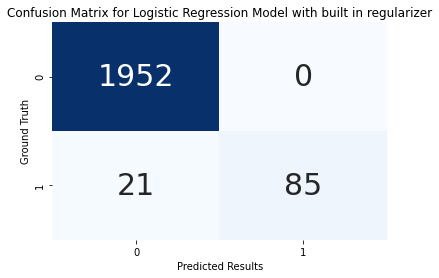

In [41]:
# show confusion matrix
y_lr = lr.predict(x_test)
cm_lr = confusion_matrix(y_test,y_lr)

ax = plt.subplot()
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False,annot_kws={"size": 30}, ax=ax)
ax.set_xlabel('Predicted Results');ax.set_ylabel('Ground Truth'); 
ax.set_title('Confusion Matrix for Logistic Regression Model with built in regularizer'); 

In [42]:
# show classification report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_lr, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      1952
     class 1       1.00      0.80      0.89       106

    accuracy                           0.99      2058
   macro avg       0.99      0.90      0.94      2058
weighted avg       0.99      0.99      0.99      2058



Note that recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.901


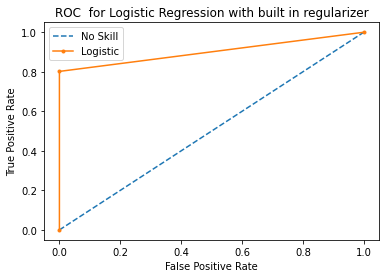

In [43]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate roc scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_lr)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# # calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_lr)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC  for Logistic Regression with built in regularizer'); 
plt.legend() # show the legend
plt.show() # show the plot

<a id='section_5.3.2'></a>
### 5.3.2 Logistic regression with only 5 features

In [44]:
# Feature selection: only keep top 5 features
feature_selector = SelectKBest(score_func=chi2, k=5)
fit2 = feature_selector.fit(x_train, y_train)

# create training dataset with selected features
x_train2 = feature_selector.fit_transform(x_train, y_train)
print(x_train2.shape)

#get selected feature names
mask = feature_selector.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_id):
     if bool:
        new_features.append(feature)
#cols = fit.get_support(indices=True) #get selected feature indexx_
#print(cols)

# make pvalue table
# set_printoptions(precision=3)
pvalue = list(zip(new_features, fit.pvalues_))
from pprint import pprint
print("(features, p-value)")
pprint(pvalue)


(4799, 5)
(features, p-value)
[('gender', 0.2165687066695535),
 ('38341003', 0.30648325931893955),
 ('422034002', 0.6309151214280989),
 ('84757009', nan),
 ('comorbid_ct', 0.36612558590486954)]


In [45]:
# trim test set to match selected features
x_test2 = x_test[new_features]
print(x_test2.shape)

(2058, 5)


In [46]:
# train Logistic Regression with seleced features
lr2 = LogisticRegression(solver='lbfgs').fit(x_train2,y_train)
acc_train = lr2.score(x_train2,y_train)*100
acc_test = lr2.score(x_test2,y_test)*100

print("Test Accuracy for train set {:.2f}%".format(acc_train))
print("Test Accuracy for test set {:.2f}%".format(acc_test))

Test Accuracy for train set 94.98%
Test Accuracy for test set 95.00%


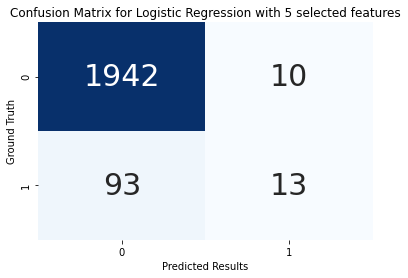

In [47]:
y_lr2 = lr2.predict(x_test2)
cm_lr2 = confusion_matrix(y_test,y_lr2)

ax = plt.subplot()
sns.heatmap(cm_lr2,annot=True,cmap="Blues",fmt="d",cbar=False,annot_kws={"size": 30}, ax=ax)
ax.set_xlabel('Predicted Results');ax.set_ylabel('Ground Truth'); 
ax.set_title('Confusion Matrix for Logistic Regression with 5 selected features'); 

In [48]:
# show classification report
# target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_lr2, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      0.99      0.97      1952
     class 1       0.57      0.12      0.20       106

    accuracy                           0.95      2058
   macro avg       0.76      0.56      0.59      2058
weighted avg       0.93      0.95      0.93      2058



**Observation**: low sensitivity but high specificity, not bad performance given the number of features

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.901


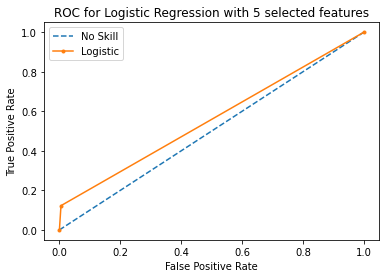

In [49]:
# generate a no skill prediction (majority class)
#ns_probs = [0 for _ in range(len(y_test))]

# calculate roc scores
#ns_auc = roc_auc_score(y_test, ns_probs)
lr2_auc = roc_auc_score(y_test, y_lr2)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# # calculate roc curves
#ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr2, lr_tpr2, _ = roc_curve(y_test, y_lr2)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr2, lr_tpr2, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC for Logistic Regression with 5 selected features'); 
plt.legend() # show the legend
plt.show() # show the plot

<a id='section_5.4'></a>
### 5.4 Non-linear Support Vector Machine (SVM) model

In [50]:
# train SVM
svm = SVC(random_state = 4, gamma='auto').fit(x_train, y_train)

acc_train = svm.score(x_train,y_train)*100
acc_test = svm.score(x_test,y_test)*100
print("Train Accuracy of SVM Algorithm: {:.2f}%".format(acc_train))
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(acc_test))


Train Accuracy of SVM Algorithm: 95.42%
Test Accuracy of SVM Algorithm: 94.85%


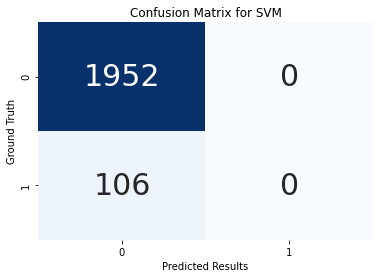

In [51]:
# show confusion matrix
y_svm = svm.predict(x_test)
cm_svm = confusion_matrix(y_test,y_svm)

ax = plt.subplot()
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False,annot_kws={"size": 30}, ax=ax)
ax.set_xlabel('Predicted Results');ax.set_ylabel('Ground Truth'); 
ax.set_title('Confusion Matrix for SVM'); 

**Observation** SVM classifies no patients getting neuropathy within 5 years of onset.  Very low sensitivity.  Performance is significantly worse than logistic regression (with regularization), possibly due to small training data volume, it's worth further investigation

<a id='section_5.5'></a>
### 5.5 Decision Tree Classifer

In [53]:
tree = DecisionTreeClassifier().fit(x_train,y_train)

acc_train = tree.score(x_train,y_train)*100
acc_test = tree.score(x_test,y_test)*100
print("Train Accuracy of Decision Tree Classifer: {:.2f}%".format(acc_train))
print("Test Accuracy of Decision Tree Classifer: {:.2f}%".format(acc_test))

Train Accuracy of Decision Tree Classifer: 100.00%
Test Accuracy of Decision Tree Classifer: 99.27%


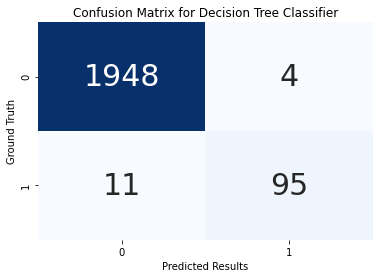

In [54]:
# show confusion matrix
y_tree = tree.predict(x_test)
cm_tree = confusion_matrix(y_test,y_tree)

ax = plt.subplot()
sns.heatmap(cm_tree,annot=True,cmap="Blues",fmt="d",cbar=False,annot_kws={"size": 30}, ax=ax)
ax.set_xlabel('Predicted Results');ax.set_ylabel('Ground Truth'); 
ax.set_title('Confusion Matrix for Decision Tree Classifier'); 

In [55]:
# show classification report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_tree, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      1952
     class 1       0.96      0.90      0.93       106

    accuracy                           0.99      2058
   macro avg       0.98      0.95      0.96      2058
weighted avg       0.99      0.99      0.99      2058



**Observation**: 0.90 sensitivity and 1.00 specificity, best performing model yet. 

No Skill: ROC AUC=0.500
SVM: ROC AUC=0.947


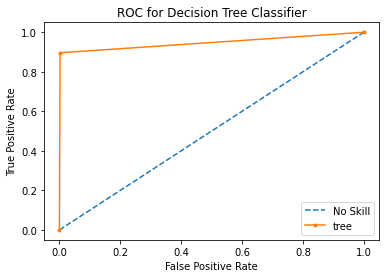

In [56]:
#generate a no skill prediction (majority class)
#ns_probs = [0 for _ in range(len(y_test))]

## calculate roc scores
#ns_auc = roc_auc_score(y_test, ns_probs)
tree_auc = roc_auc_score(y_test, y_tree)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('SVM: ROC AUC=%.3f' % (tree_auc))

## calculate roc curves
#ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
tree_fpr, tree_tpr, _ = roc_curve(y_test, y_tree)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(tree_fpr, tree_tpr, marker='.', label='tree')

# axis labels
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC for Decision Tree Classifier'); 
plt.legend() # show the legend
plt.show() # show the plot

## Synetha metabolic syndrome disease (which includes diabetes) data generation logic

<img src="https://synthetichealth.github.io/synthea/graphviz/metabolic_syndrome_disease.png" style="float: left; width: 40%; margin-bottom: 0.5em;">

https://synthetichealth.github.io/synthea/graphviz/metabolic_syndrome_disease.png